In [15]:
raw_dset_soap["metadata"].item()


{'n_spectra_file': 3292,
 'n_spectra': 100,
 'n_pixels': 5000,
 'wavemin': 5000.0,
 'wavemax': 5050.0,
 'downscaling_factor': 2,
 'smooth_after_downscaling': True,
 'smooth_kernel_size': 3,
 'add_photon_noise': False,
 'snr_target': 300.0,
 'noise_seed': 42,
 'original_pixels': 10000,
 'downscaled_pixels': 5000,
 'batch_size': 100,
 'planets_periods': [50],
 'planets_amplitudes': [0.1],
 'planets_phases': [0.0],
 'activity_definition': 'activity = spectra_pre_noise_pre_planets - template'}

In [41]:
raw_dset_soap.keys()

KeysView(NpzFile '/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/npz_datasets/soapgpu_ns100_5000-5050_dx2_sm3_p50_k0p1_phi0.npz' with keys: wavegrid, template, spectra, activity, time_values...)

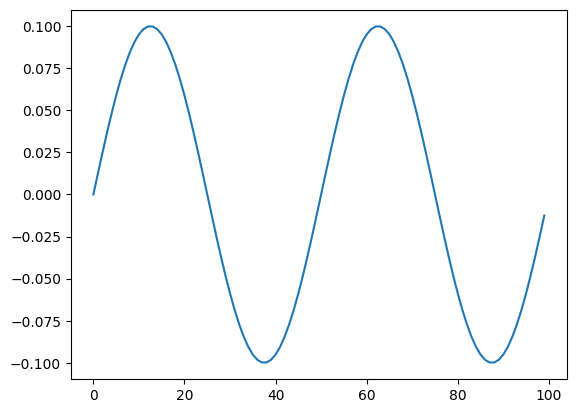

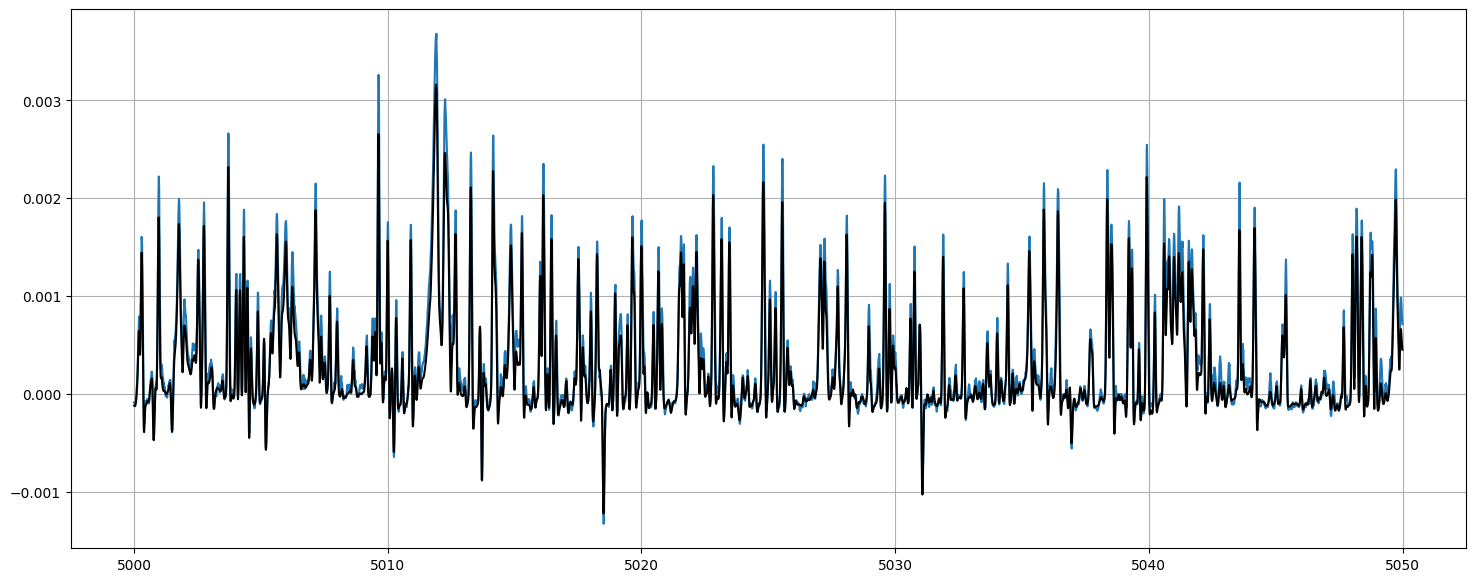

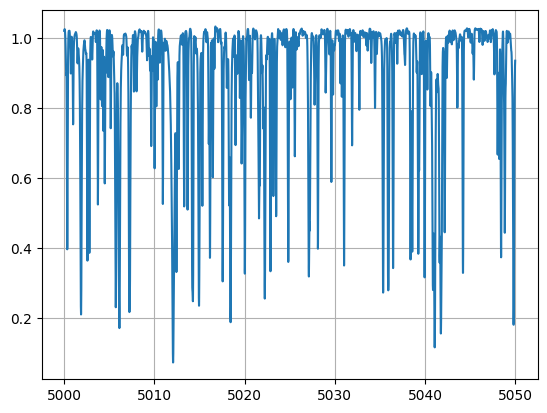

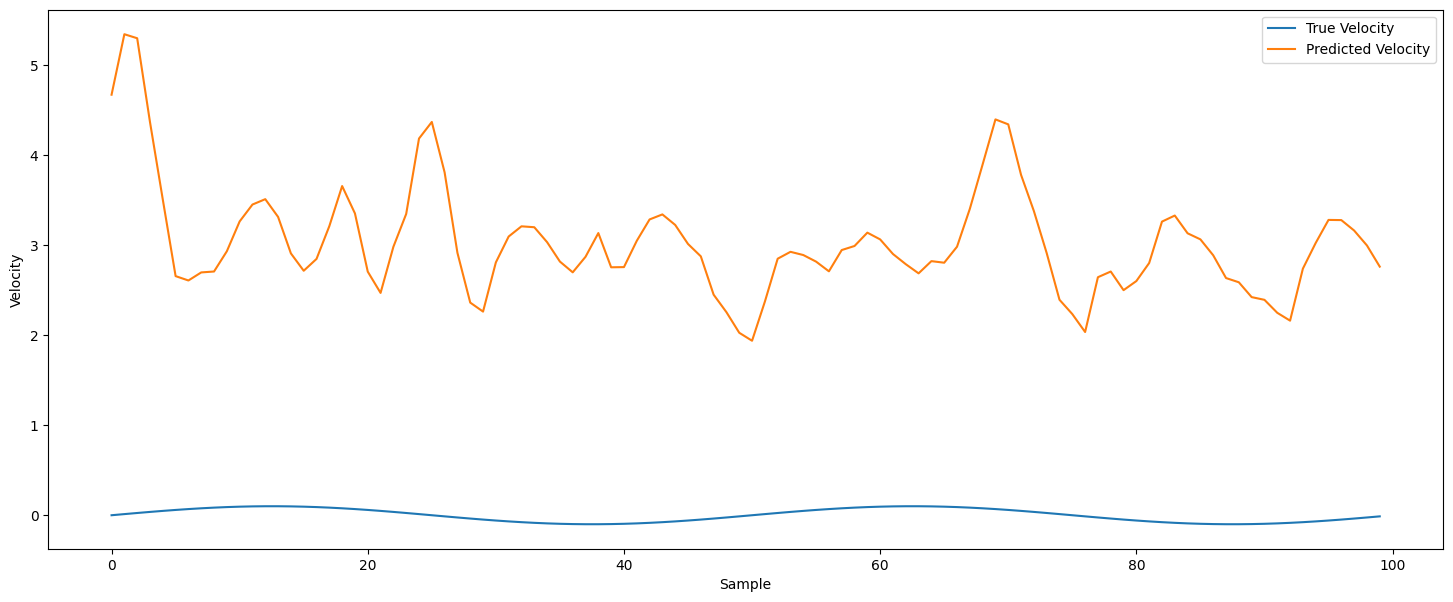

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from src.modeling.models import AESTRA
import torch

raw_dset_soap = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/npz_datasets/soapgpu_ns100_5000-5050_dx2_sm3_p50_k0p1_phi0.npz",
    allow_pickle=True,
)

wavegrid = raw_dset_soap["wavegrid"]
template = raw_dset_soap["template"]
spectra = raw_dset_soap["spectra"]
true_activity = raw_dset_soap["activity"]
v_true = raw_dset_soap["v_true"]

plt.plot(v_true)

model = AESTRA(
    n_pixels=raw_dset_soap["metadata"].item()["n_pixels"],
    b_obs=torch.zeros_like(torch.tensor(raw_dset_soap["spectra"][0])),
    b_rest=torch.zeros_like(torch.tensor(raw_dset_soap["spectra"][0])),
)

model.load_state_dict(
    torch.load(
        "../experiments/soapgpu_ns100_5000-5050_dx2_sm3_p50_k0p1_phi0/models/aestra_final.pth"
    )["model_state_dict"]
)

model = model.to("cuda")

model.eval()

all_v = []
all_y_act = []
all_s = []
all_yrest = []
for spectra in spectra:
    r_obs = torch.tensor(spectra, device="cuda") - model.b_obs.unsqueeze(0)
    v = model.rvestimator(r_obs)
    all_v.append(v.detach().cpu().numpy())
    y_act, s = model.spender(r_obs)
    all_y_act.append(y_act.squeeze(0).detach().cpu().numpy())
    all_s.append(s.squeeze(0).detach().cpu().numpy())
    all_yrest.append(y_act.squeeze(0).detach().cpu().numpy() + model.b_rest.detach().cpu().numpy())


plt.figure(figsize=(18, 7))
plt.plot(wavegrid, all_y_act[0], label="Predicted CCF")
plt.plot(wavegrid, true_activity[0], label="True CCF", color="k")
plt.grid()
plt.show()

plt.plot(wavegrid, all_yrest[0] , label="Predicted Spectrum")
plt.grid()
plt.show()

plt.figure(figsize=(18, 7))
plt.plot(v_true - v_true[0], label="True Velocity")
plt.plot(all_v, label="Predicted Velocity")
plt.xlabel("Sample")
plt.ylabel("Velocity")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.ccf import get_full_ccf_analysis

raw_dset = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/npz_datasets/soapgpu_ns3287_5000-5050_dx2_sm3_snr300_p100_k0p1_phi0.npz",
    allow_pickle=True,
)

print(raw_dset.files)

wavegrid = raw_dset["wavegrid"]
template = raw_dset["template"]
spectra = raw_dset["spectra"]
activity = raw_dset["activity"]
time_values = raw_dset["time_values"]
v_true = raw_dset["v_true"]
metadata = raw_dset["metadata"].item()
spectra_no_activity = raw_dset["spectra_no_activity"]

ccf_data = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/ccf_results/ccf_analysis_results.npz",
    allow_pickle=True
)

print(ccf_data.files)

all_rvs_ccf = ccf_data["rvs"]
all_time_values = ccf_data["time_values"]
random_ccf = ccf_data["raw_ccfs"][np.random.randint(0, ccf_data["raw_ccfs"].shape[0])]
v_grid_ccf = ccf_data["v_grid"]
ccf_params = ccf_data["metadata"].item()

full_ccf_analysis = get_full_ccf_analysis(
    spectra=spectra,
    wavegrid=wavegrid,
    v_grid=v_grid_ccf,
    window_size_velocity=ccf_params["window_size_velocity"],
)

v_apparent = full_ccf_analysis["rv"]

['wavegrid', 'template', 'spectra', 'activity', 'time_values', 'v_true', 'metadata', 'spectra_no_activity', 'weights_fid']
['rvs', 'depths', 'fwhms', 'spans', 'continuum', 'amplitude', 'raw_ccfs', 'v_grid', 'wavegrid', 'time_values', 'metadata']


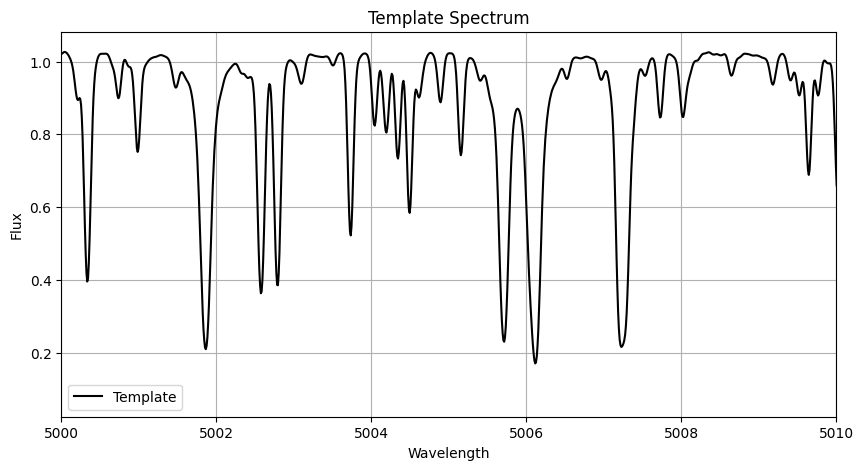

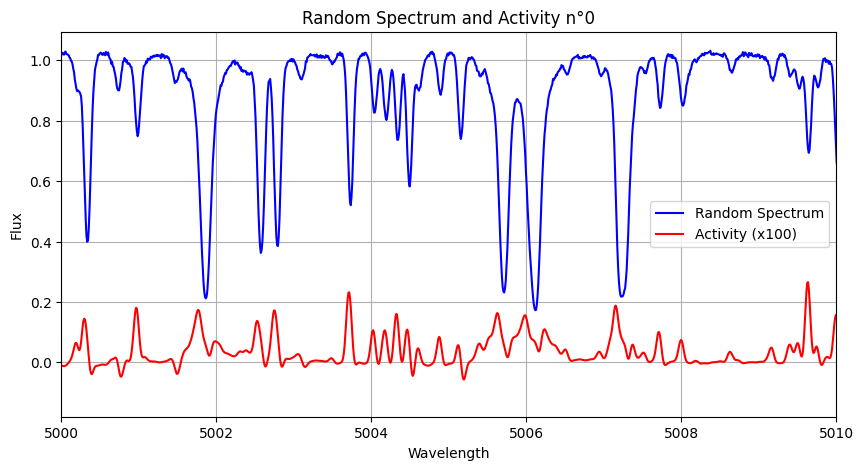

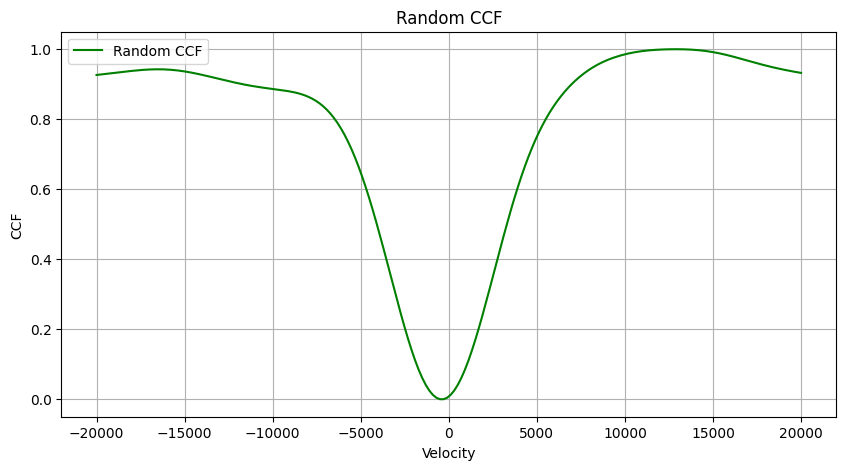

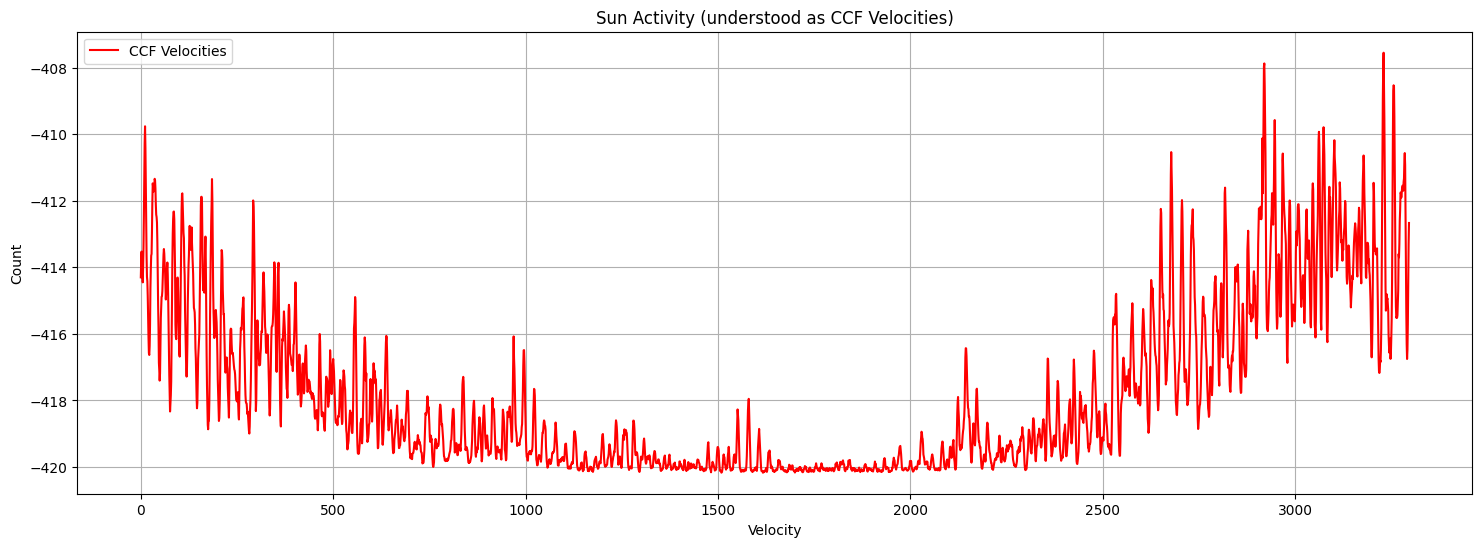

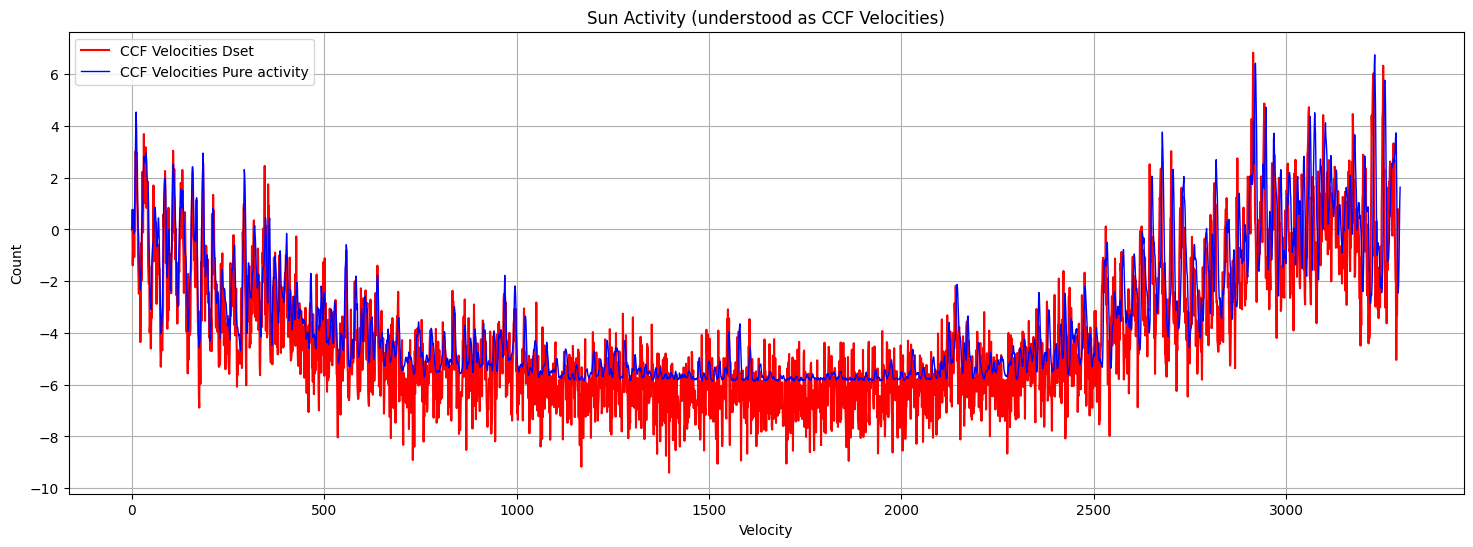

In [23]:
xlim = (5000, 5010)
# Plot du template
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(wavegrid, template, color="k", label="Template")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.grid()
plt.title("Template Spectrum")
plt.xlim(xlim)
plt.legend()
plt.show()

# Plot d'un spectre random et de son activity (x 20)

# random_index = np.random.randint(0, spectra.shape[0])
random_index = 0
plt.figure(figsize=(10, 5))
plt.plot(wavegrid, spectra[random_index], color="b", label="Random Spectrum")
plt.plot(wavegrid, 100 * activity[random_index], color="r", label="Activity (x100)")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.grid()
plt.title(f"Random Spectrum and Activity n°{random_index}")
plt.legend()
plt.xlim(xlim)
plt.show()

# Plot d'une ccf random
plt.figure(figsize=(10, 5))
plt.plot(v_grid_ccf, random_ccf, color="g", label="Random CCF")
plt.xlabel("Velocity")
plt.ylabel("CCF")
plt.grid()
plt.title(f"Random CCF")
plt.legend()
plt.show()

# Plot des vitesses obtenues par ccf sur tout le dset
plt.figure(figsize=(18, 6))
plt.plot(all_time_values, all_rvs_ccf, color="red", label="CCF Velocities")
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.grid()
plt.title(f"Sun Activity (understood as CCF Velocities)")    
plt.legend()
plt.show()

# Vitesses obtenues par ccf sur le dataset (avec planète injectée)

plt.figure(figsize=(18, 6))
plt.plot(time_values, v_apparent - v_apparent[0], color="red", label="CCF Velocities Dset")
time_indices = time_values.astype(int)
plt.plot(
    all_time_values[time_indices],
    all_rvs_ccf[time_indices] - all_rvs_ccf[time_indices][0],
    color="blue",
    linewidth=1,
    label="CCF Velocities Pure activity",
)
# plt.plot(
#     time_values,
#     v_apparent_amp_x5 - v_apparent_amp_x5[0],
#     color="orange",
#     linewidth=1,
#     label="CCF Velocities Dset (Amp x5)",
# )
# plt.plot(time_values, v_true, color="green", label="True Velocities")
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.grid()
plt.title(f"Sun Activity (understood as CCF Velocities)")    
plt.legend()
plt.show()

In [7]:
len(all_time_values)

3292